# <mark>**1) Query Store**</mark>

[https://medium.com/codex/introduction-to-sql-server-query-store-9e45a563a502](https://medium.com/codex/introduction-to-sql-server-query-store-9e45a563a502)

https://docs.microsoft.com/en-us/sql/relational-databases/performance/how-query-store-collects-data?WT.mc\_id=DP-MVP-4029181&view=sql-server-ver16

# <mark>Conteudo</mark>

1. **O que é ?**
2. **quando utilizar?**
3. **Como Habilitar ?**
4. **Configurações Iniciais**
5. **Arquitetura**
6. **Melhores práticas**
7. **Demo**
8. **DW**

# **<mark>1) O que é ?</mark>**

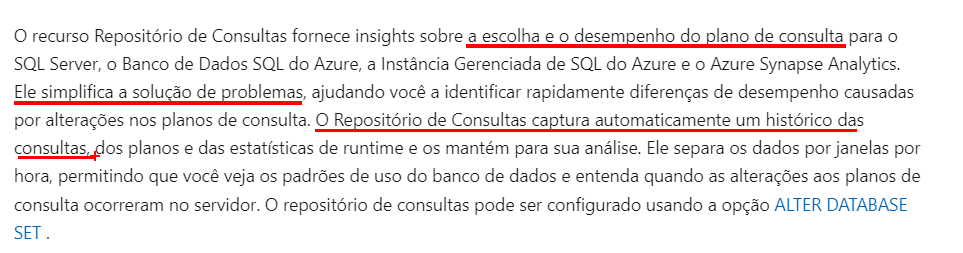

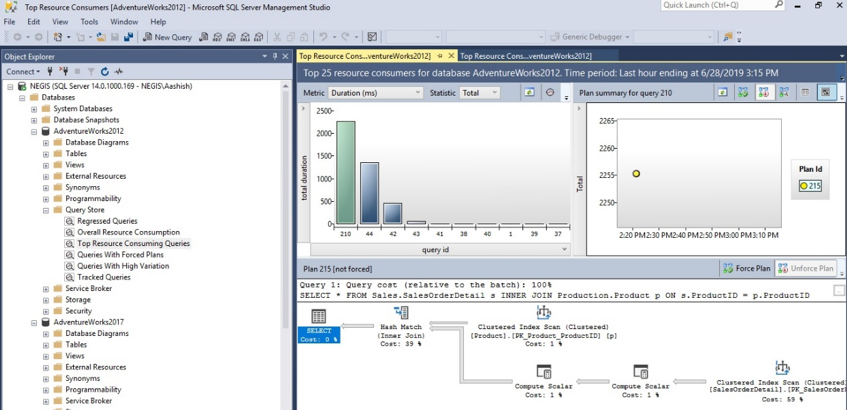

# <span style="font-size: 28px; background-color: yellow;"><b>2) Quando Utilizar</b></span>

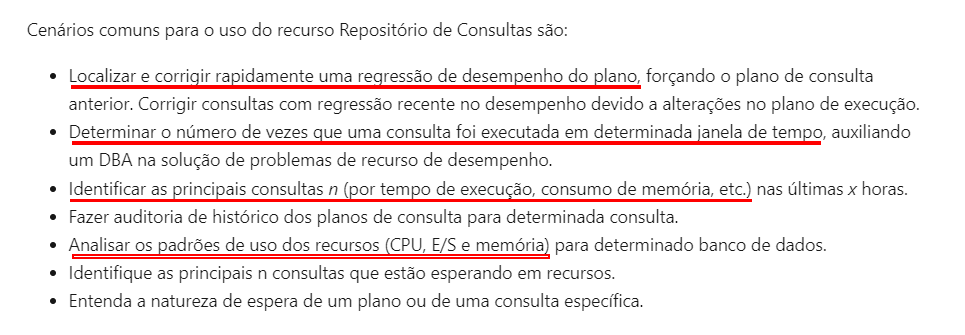

# **<mark>3) Como Habilitar ?</mark>**

In [1]:
ALTER DATABASE [TreinamentoSQL]
SET QUERY_STORE = ON (OPERATION_MODE = READ_WRITE);

Commands completed successfully.

Total execution time: 00:00:00.011

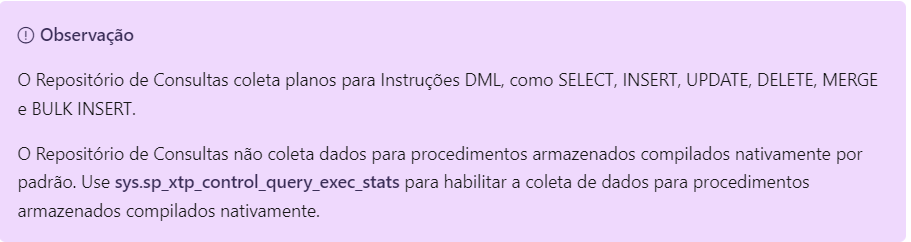

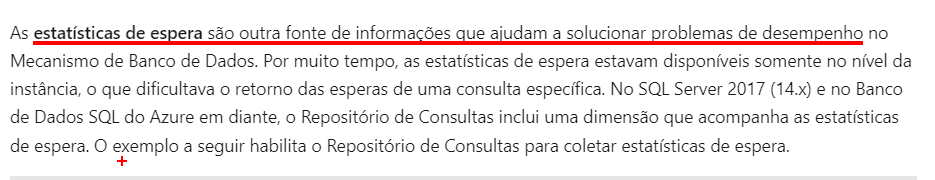

In [2]:
ALTER DATABASE [TreinamentoSQL]
SET QUERY_STORE = ON ( WAIT_STATS_CAPTURE_MODE  = ON ,OPERATION_MODE = READ_WRITE);

Commands completed successfully.

Total execution time: 00:00:00.002

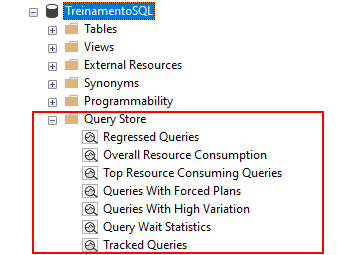

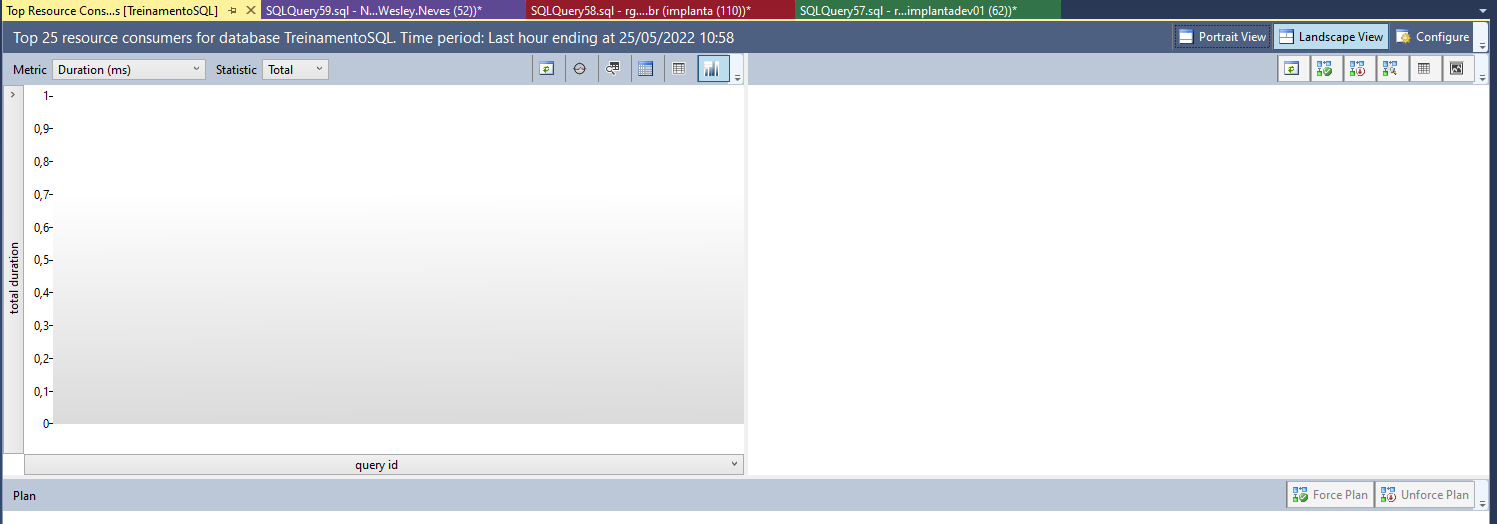

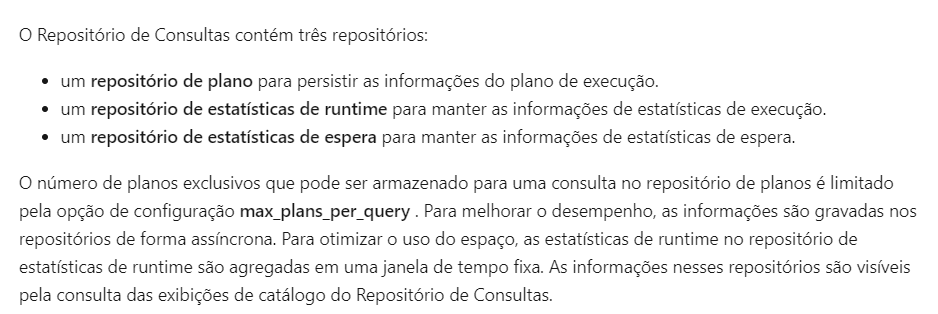

# **<mark>4) Configuracoes Iniciais ?</mark>**

In [3]:
SELECT * FROM sys.database_query_store_options

(1 row affected)

Total execution time: 00:00:00.074

desired_state,desired_state_desc,actual_state,actual_state_desc,readonly_reason,current_storage_size_mb,flush_interval_seconds,interval_length_minutes,max_storage_size_mb,stale_query_threshold_days,max_plans_per_query,query_capture_mode,query_capture_mode_desc,capture_policy_execution_count,capture_policy_total_compile_cpu_time_ms,capture_policy_total_execution_cpu_time_ms,capture_policy_stale_threshold_hours,size_based_cleanup_mode,size_based_cleanup_mode_desc,wait_stats_capture_mode,wait_stats_capture_mode_desc,actual_state_additional_info
2,READ_WRITE,2,READ_WRITE,0,0,900,30,4096,30,10,2,AUTO,NULL,NULL,NULL,NULL,1,AUTO,1,ON,


\# Para saber mais sobre configurações e melhores práticas visite aqui

[https://docs.microsoft.com/pt-br/sql/relational-databases/performance/best-practice-with-the-query-store?view=sql-server-ver16#Configure](https://docs.microsoft.com/pt-br/sql/relational-databases/performance/best-practice-with-the-query-store?view=sql-server-ver16#Configure)

https://docs.microsoft.com/pt-br/sql/relational-databases/system-catalog-views/sys-database-query-store-options-transact-sql?view=sql-server-ver16

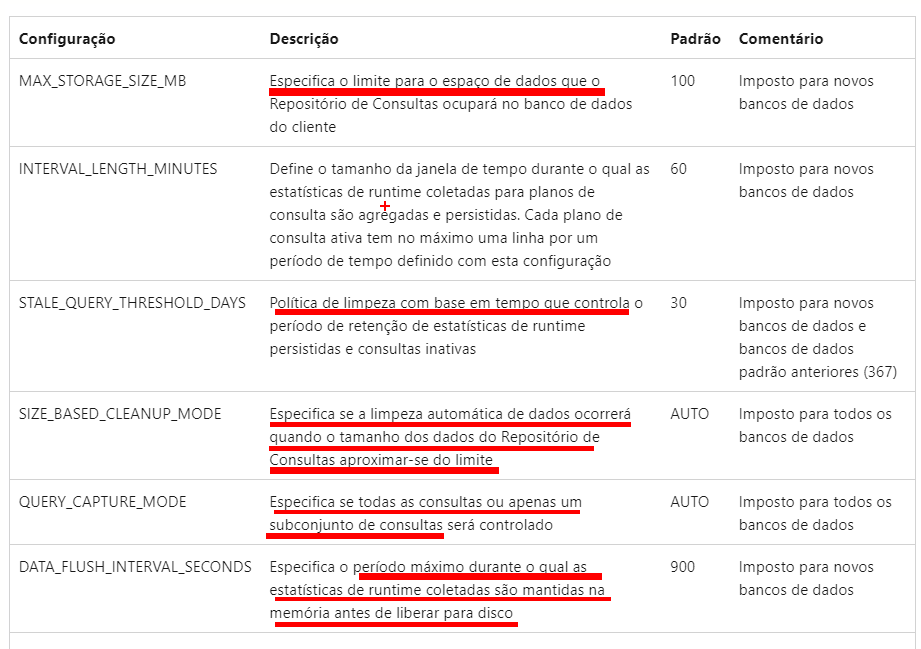

<span style="color: rgb(23, 23, 23); font-family: &quot;Segoe UI&quot;, SegoeUI, &quot;Helvetica Neue&quot;, Helvetica, Arial, sans-serif; font-size: 16px; background-color: rgb(255, 255, 255);">script a seguir define um novo valor para&nbsp;</span> <span style="box-sizing: inherit; outline-color: inherit; font-weight: 600; color: rgb(23, 23, 23); font-family: &quot;Segoe UI&quot;, SegoeUI, &quot;Helvetica Neue&quot;, Helvetica, Arial, sans-serif; font-size: 16px; background-color: rgb(255, 255, 255);">Tamanho Máximo (MB)</span>

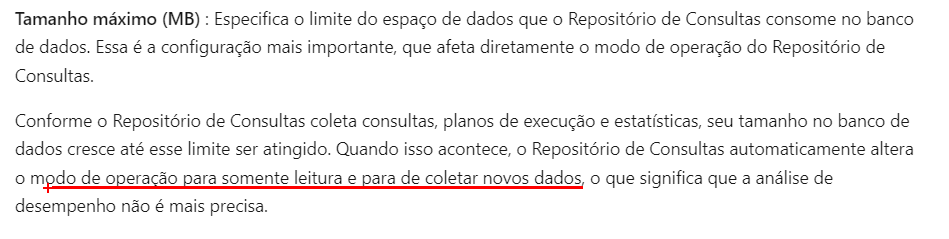

In [8]:
ALTER DATABASE [TreinamentoSQL]
SET QUERY_STORE (MAX_STORAGE_SIZE_MB = 1024);

Commands completed successfully.

Total execution time: 00:00:00.075

In [4]:

 DECLARE @Database VARCHAR(200) = DB_NAME();


DECLARE @comand1 VARCHAR(200) = CONCAT('ALTER DATABASE ', QUOTENAME(@Database), '  SET QUERY_STORE CLEAR');
EXEC (@comand1);

DECLARE @query VARCHAR(MAX)
    = CONCAT(
                'ALTER DATABASE ',
                QUOTENAME(@Database),
                ' SET QUERY_STORE = ON
    (
      OPERATION_MODE = READ_WRITE,
      CLEANUP_POLICY = ( STALE_QUERY_THRESHOLD_DAYS = 30 ),
      DATA_FLUSH_INTERVAL_SECONDS = 900,
      MAX_STORAGE_SIZE_MB = 4096, --4GB
      INTERVAL_LENGTH_MINUTES = 30,
      SIZE_BASED_CLEANUP_MODE = AUTO,
      MAX_PLANS_PER_QUERY = 10,
      WAIT_STATS_CAPTURE_MODE = ON,
      QUERY_CAPTURE_MODE = AUTO
    );'
            );

EXEC (@query);

Commands completed successfully.

Total execution time: 00:00:00.010

## <mark>\# Verificar se o Query Store está em estado gravação e leitura</mark>

In [6]:


SELECT
   DB_NAME() as "Database Name",
   actual_state_desc as "Actual State",
   FORMAT(current_storage_size_mb, 'N0') as "Current Storage Size (MB)",
   FORMAT(max_storage_size_mb, 'N0') as "Max Storage Size (MB)",
   (CAST(current_storage_size_mb AS FLOAT)/CAST(max_storage_size_mb AS FLOAT)) *100 "Storage utilization %",
   CASE
      WHEN readonly_reason = 1 THEN 'Database in read-only mode'
      WHEN readonly_reason = 2 THEN 'Database in single-user mode'
      WHEN readonly_reason = 4 THEN 'Database in emergency mode'
      WHEN readonly_reason = 8 THEN 'Database is secondary replica'
      WHEN readonly_reason = 65536 THEN 'Query Store has reached the size limit set by the MAX_STORAGE_SIZE_MB option'
      WHEN readonly_reason = 131072 THEN 'The number of different statements in Query Store has reached the internal memory limit'
      WHEN readonly_reason = 262144 THEN 'Size of in-memory items waiting to be persisted on disk has reached the internal memory limit'
      WHEN readonly_reason = 524288 THEN 'User database has reached disk size limit'
      ELSE 'N\A'
   END as "Read only Reason",
   stale_query_threshold_days as "Cleanup policy",
   size_based_cleanup_mode_desc as "Size based cleanup mode"
FROM sys.database_query_store_options
GO


(1 row affected)

Total execution time: 00:00:00.024

Database Name,Actual State,Current Storage Size (MB),Max Storage Size (MB),Storage utilization %,Read only Reason,Cleanup policy,Size based cleanup mode
TreinamentoSQL,READ_WRITE,0,4.096,0,N\A,30,AUTO


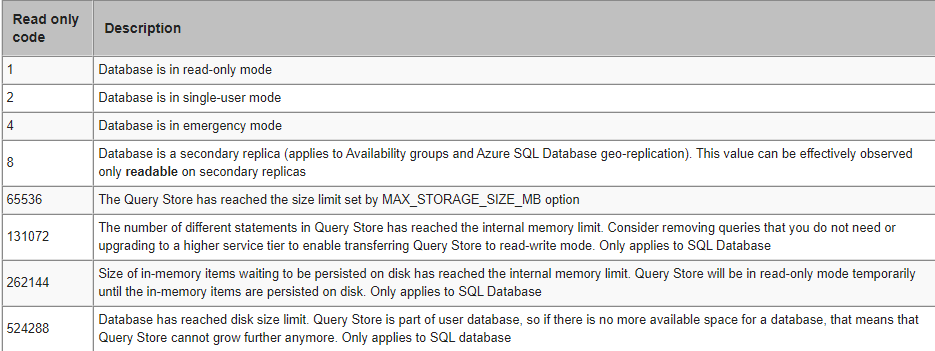

Agora vamos falar de query

  

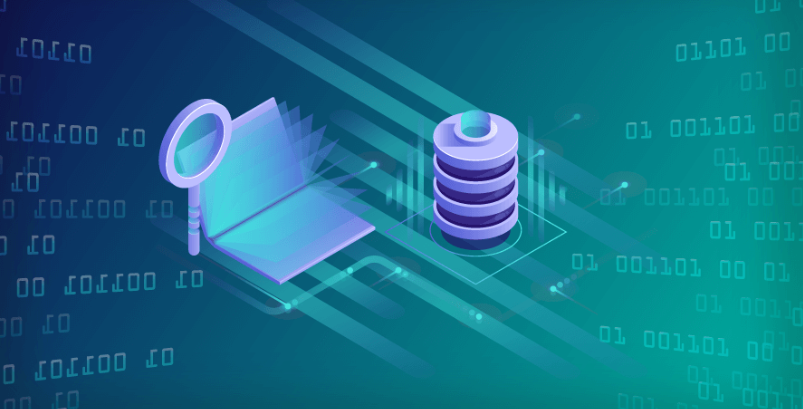

# <mark>**5) Arquiterura**</mark>

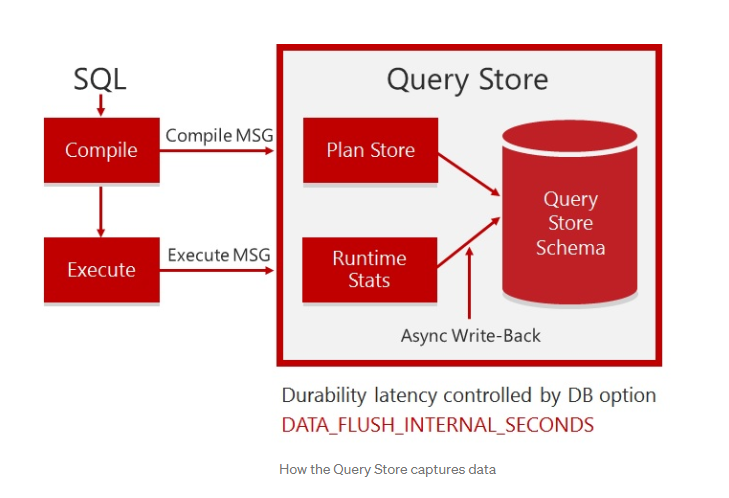

## Sempre que o SQL Server compila uma consulta, <mark>uma mensagem de compilação chega ao Query Store</mark> e o plano de execução da consulta é armazenado. Da mesma forma, quando uma consulta é executada, <mark>uma mensagem de execução chega ao Query Store</mark>, as estatísticas de tempo de execução são armazenadas no Query Store após a execução da consulta. A Query Store agrega as informações de acordo com a granularidade de tempo que você escolheu

# **<mark>Diagrama ER</mark>**

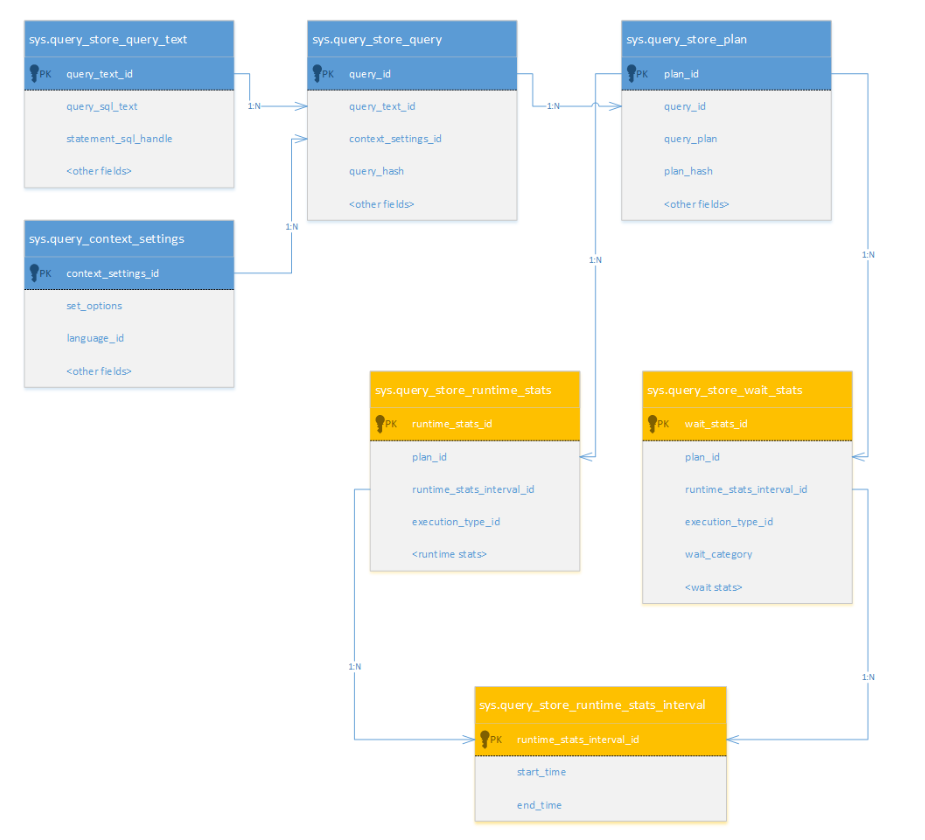

# <mark>**\# Resumo de responsabilidades**</mark>

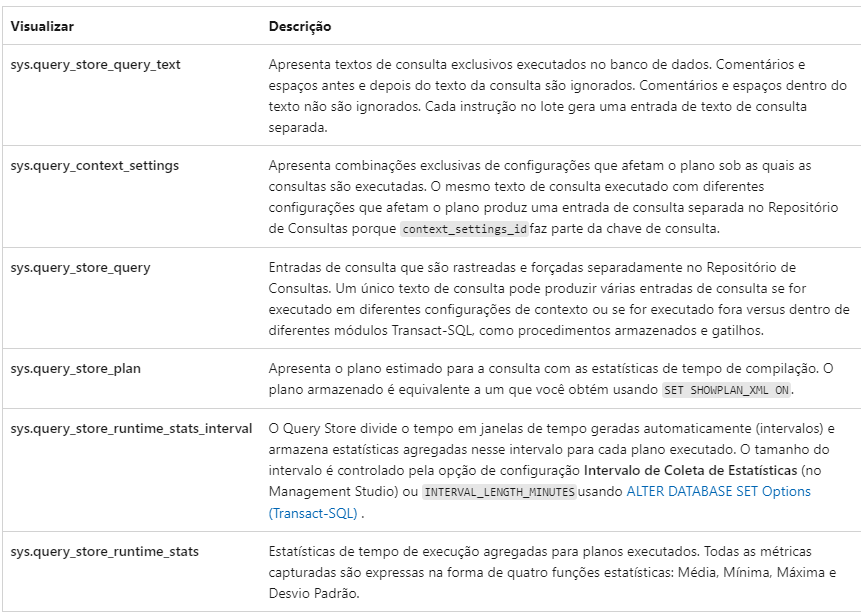

## **<mark>1) sys.query\_store\_query\_text</mark>**

Texto de consulta exclusivo é armazenado apenas uma vez no DMV [sys.query\_store\_query\_text](https://docs.microsoft.com/en-us/sql/relational-databases/system-catalog-views/sys-query-store-query-text-transact-sql?WT.mc_id=DP-MVP-4029181) OBS: As colunas mais importantes neste DMV são _query\_text\_id_ e _statement\_sql\_handle_ . Em particular, _query\_text\_id_ é usado para identificar uma consulta na qual você força o plano de consulta.

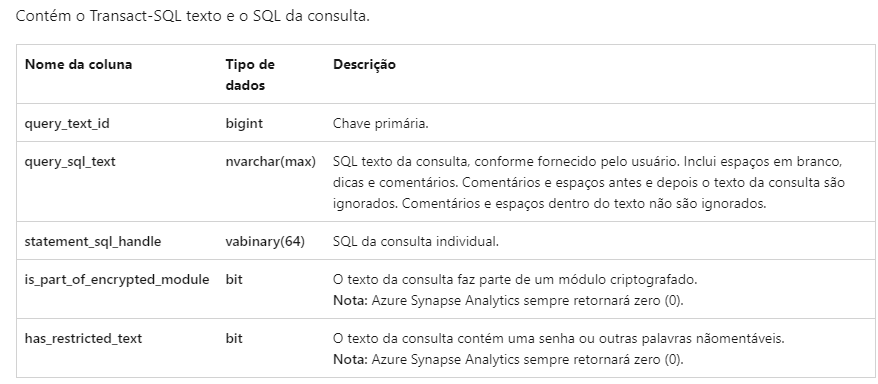

In [ ]:
SELECT * FROM dbo.Lancamentos AS L



In [ ]:
-- Rodar com um paramentro string
SELECT * FROM dbo.Lancamentos AS L
WHERE L.NumeroLancamento ='23813'



In [ ]:
-- Rodar com um paramentro abaixo de 32 mil (smallint)
SELECT * FROM dbo.Lancamentos AS L
WHERE L.NumeroLancamento =23813



In [ ]:
-- Rodar com um paramentro acima de 32 mil (int)
SELECT * FROM dbo.Lancamentos AS L
WHERE L.NumeroLancamento =34813

In [14]:
SELECT  * FROM sys.query_store_query_text

(4 rows affected)

Total execution time: 00:00:00.004

query_text_id,query_sql_text,statement_sql_handle,is_part_of_encrypted_module,has_restricted_text
1,SELECT * FROM dbo.Lancamentos AS L,0x09007E8B9BE5A94655464FD6754351EC57BC0000000000000000000000000000000000000000000000000000,0,0
2,(@1 varchar(8000))SELECT * FROM [dbo].[Lancamentos] [L] WHERE [L].[NumeroLancamento]=@1,0x09008F329948D9C30224FCF1BB6C31321B8F0000000000000000000000000000000000000000000000000000,0,0
3,(@1 smallint)SELECT * FROM [dbo].[Lancamentos] [L] WHERE [L].[NumeroLancamento]=@1,0x09000C8BB718C56EF5C46103B94D5EEAD6B80000000000000000000000000000000000000000000000000000,0,0
4,(@1 int)SELECT * FROM [dbo].[Lancamentos] [L] WHERE [L].[NumeroLancamento]=@1,0x09001038CB98A09780EA75A78BC6CA5E3BCD0000000000000000000000000000000000000000000000000000,0,0


## **<mark>2) [sys.query\_store\_query](https://docs.microsoft.com/en-us/sql/relational-databases/system-catalog-views/sys-query-store-query-transact-sql?WT.mc_id=DP-MVP-4029181)</mark>**

## O plano de execução é influenciado pelas Opções ANSI, então para cada linha do Query\_Text podemos ter várias linhas diferentes no [sys.query\_store\_query](https://docs.microsoft.com/en-us/sql/relational-databases/system-catalog-views/sys-query-store-query-transact-sql?WT.mc_id=DP-MVP-4029181)

  

https://docs.microsoft.com/pt-br/sql/relational-databases/system-catalog-views/sys-query-store-query-transact-sql?view=sql-server-ver16

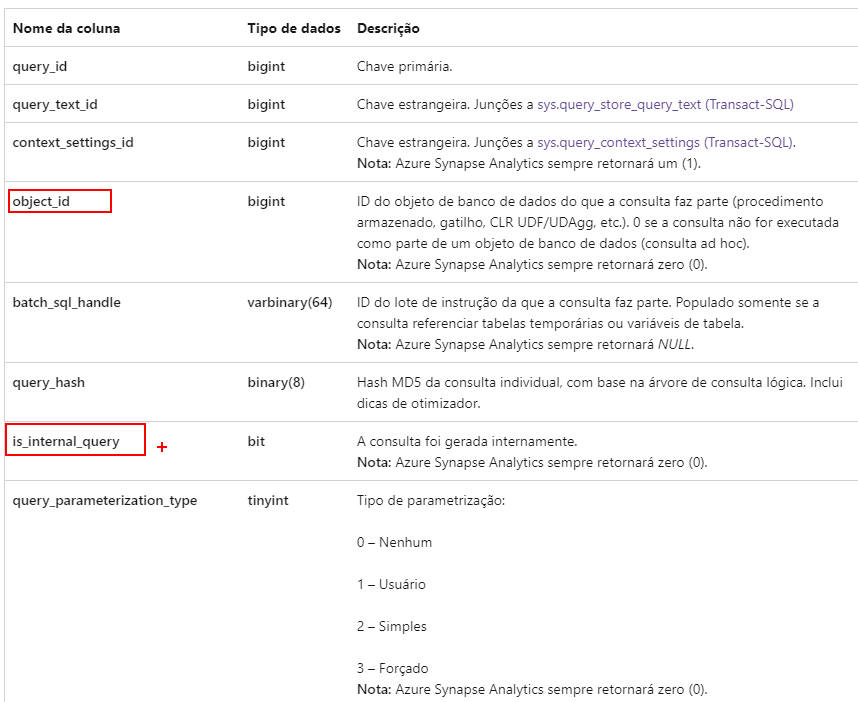

In [20]:



SELECT QSQT.query_text_id,
       QSQT.query_sql_text,
       QSQT.statement_sql_handle,
       QSQ.query_id,
       QSQ.context_settings_id,
       QSQ.query_hash,
       QSQ.is_internal_query,
       QSQ.query_parameterization_type_desc,
       QSQ.last_execution_time,
       QSQ.last_compile_start_time,
       QSQ.count_compiles,
       QSQ.[last_compile_duration/sec],
       QSQ.[avg_compile_duration/sec],
       QSQ.[last_bind_duration/sec],
       QSQ.[avg_bind_duration/sec],
       QSQ.[avg_optimize_duration/sec],
       QSQ.[last_optimize_duration/sec],
       QSQ.[avg_optimize_cpu_time/sec],
       QSQ.[last_optimize_cpu_time/sec],
       QSQ.[last_optimize_cpu_time/sec],
       QSQ.[avg_compile_memory_kb/MB],
       QSQ.[last_compile_memory_kb/MB],
       QSQ.[max_compile_memory_kb/MB]
FROM sys.query_store_query_text AS QSQT
    JOIN
    (
        SELECT QSQ.query_text_id,
               QSQ.query_id,
               QSQ.context_settings_id,
               QSQ.query_hash,
               QSQ.is_internal_query,
               QSQ.query_parameterization_type_desc,
               QSQ.last_execution_time,
               QSQ.last_compile_start_time,
               QSQ.count_compiles,
               [last_compile_duration/sec] = CAST((QSQ.last_compile_duration / 1000000.0) AS DECIMAL(18, 4)),
               [avg_compile_duration/sec] = CAST((QSQ.avg_compile_duration / 1000000.0) AS DECIMAL(18, 4)),
               [last_bind_duration/sec] = CAST((QSQ.last_bind_duration / 1000000.0) AS DECIMAL(18, 4)),
               [avg_bind_duration/sec] = CAST((QSQ.avg_bind_duration / 1000000.0) AS DECIMAL(18, 4)),
               [avg_optimize_duration/sec] = CAST((QSQ.avg_optimize_duration / 1000000.0) AS DECIMAL(18, 4)),
               [last_optimize_duration/sec] = CAST((QSQ.last_optimize_duration / 1000000.0) AS DECIMAL(18, 4)),
               [avg_optimize_cpu_time/sec] = CAST((QSQ.avg_optimize_cpu_time / 1000000.0) AS DECIMAL(18, 4)),
               [last_optimize_cpu_time/sec] = CAST((QSQ.last_optimize_cpu_time / 1000000.0) AS DECIMAL(18, 4)),
               [avg_compile_memory_kb/MB] = (QSQ.avg_compile_memory_kb * 8) / 1024.0,
               [last_compile_memory_kb/MB] = (QSQ.last_compile_memory_kb * 8) / 1024.0,
               [max_compile_memory_kb/MB] = (QSQ.max_compile_memory_kb * 8) / 1024.0
        FROM sys.query_store_query AS QSQ
    ) QSQ
        ON QSQ.query_text_id = QSQT.query_text_id;


(9 rows affected)

Total execution time: 00:00:00.067

query_text_id query_sql_text statement_sql_handle query_id context_settings_id query_hash is_internal_query query_parameterization_type_desc last_execution_time last_compile_start_time count_compiles last_compile_duration/sec avg_compile_duration/sec last_bind_duration/sec avg_bind_duration/sec avg_optimize_duration/sec last_optimize_duration/sec avg_optimize_cpu_time/sec last_optimize_cpu_time/sec last_optimize_cpu_time/sec avg_compile_memory_kb/MB last_compile_memory_kb/MB max_compile_memory_kb/MB 1 SELECT * FROM dbo.Lancamentos AS L 0x09007E8B9BE5A94655464FD6754351EC57BC0000000000000000000000000000000000000000000000000000 15 2 0xE86E7CF8CD8DAC67 0 None 2022-05-27 17:57:21.2130000 +00:00 2022-05-27 17:57:00.5470000 +00:00 1 0.0004 0.0004 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 1 1.000000 1.000000 2 (@1 varchar(8000))SELECT * FROM [dbo].[Lancamentos] [L] WHERE [L].[NumeroLancamento]=@1 0x09008F329948D9C30224FCF1BB6C31321B8F0000000000000000000000000000000000000000000000000000 17 2 0xC41618474C8A0F18 0 Simple 2022-05-27 17:57:48.2870000 +00:00 2022-05-27 17:57:48.1970000 +00:00 1 0.0536 0.0536 0.0002 0.0002 0.0534 0.0534 0.0082 0.0082 0.0082 1,625 1.625000 1.625000 3 (@1 smallint)SELECT * FROM [dbo].[Lancamentos] [L] WHERE [L].[NumeroLancamento]=@1 0x09000C8BB718C56EF5C46103B94D5EEAD6B80000000000000000000000000000000000000000000000000000 18 2 0xC41618474C8A0F18 0 Simple 2022-05-27 17:57:51.8400000 +00:00 2022-05-27 17:57:51.7900000 +00:00 1 0.0012 0.0012 0.0002 0.0002 0.0009 0.0009 0.0009 0.0009 0.0009 1,625 1.625000 1.625000 4 (@1 int)SELECT * FROM [dbo].[Lancamentos] [L] WHERE [L].[NumeroLancamento]=@1 0x09001038CB98A09780EA75A78BC6CA5E3BCD0000000000000000000000000000000000000000000000000000 20 2 0xC41618474C8A0F18 0 Simple 2022-05-27 17:58:31.5030000 +00:00 2022-05-27 17:58:31.4700000 +00:00 1 0.0011 0.0011 0.0002 0.0002 0.0009 0.0009 0.0009 0.0009 0.0009 1,625 1.625000 1.625000 8 (@_msparam_0 nvarchar(4000))SELECT
dtb.name AS [Name]
FROM
master.sys.databases AS dtb
WHERE
(dtb.name=@_msparam_0) 0x0900215D80B45C458D9B2768889A8E72E69C0000000000000000000000000000000000000000000000000000 24 1 0xB69EBCCE4ABDD8E9 0 User 2022-05-27 19:01:49.1500000 +00:00 2022-05-27 19:01:49.1000000 +00:00 1 0.0105 0.0105 0.0010 0.0010 0.0095 0.0095 0.0095 0.0095 0.0095 26,25 26.250000 26.250000 9 (@_msparam_0 nvarchar(4000))SELECT
CAST(CHARINDEX(N'_CS_', dtb.collation_name) AS bit) AS [CaseSensitive],
dtb.name AS [DatabaseName2]
FROM
master.sys.databases AS dtb
WHERE
(dtb.name=@_msparam_0) 0x090017874D3FC709E99482C397AB8EAE5B540000000000000000000000000000000000000000000000000000 25 1 0x4F3AD3BE97B3BEE6 0 User 2022-05-27 19:01:49.1570000 +00:00 2022-05-27 19:01:49.1170000 +00:00 1 0.0106 0.0106 0.0009 0.0009 0.0097 0.0097 0.0097 0.0097 0.0097 26,5 26.500000 26.500000 5 (@_msparam_0 nvarchar(4000),@_msparam_1 nvarchar(4000),@_msparam_2 nvarchar(4000))SELECT
udf.name AS [Name],
udf.object_id AS [ID],
udf.create_date AS [CreateDate],
udf.modify_date AS [DateLastModified],
ISNULL(sudf.name, N'') AS [Owner],
CAST(case when udf.principal_id is null then 1 else 0 end AS bit) AS [IsSchemaOwned],
SCHEMA_NAME(udf.schema_id) AS [Schema],
CAST(
 case 
 when udf.is_ms_shipped = 1 then 1
 when (
 select 
 major_id 
 from 
 sys.extended_properties 
 where 
 major_id = udf.object_id and 
 minor_id = 0 and 
 class = 1 and 
 name = N'microsoft_database_tools_support') 
 is not null then 1
 else 0
end 
 AS bit) AS [IsSystemObject],
usrt.name AS [DataType],
s1ret_param.name AS [DataTypeSchema],
ISNULL(baset.name, N'') AS [SystemType],
CAST(CASE WHEN baset.name IN (N'nchar', N'nvarchar') AND ret_param.max_length <> -1 THEN ret_param.max_length/2 ELSE ret_param.max_length END AS int) AS [Length],
CAST(ret_param.precision AS int) AS [NumericPrecision],
CAST(ret_param.scale AS int) AS [NumericScale],
ISNULL(xscret_param.name, N'') AS [XmlSchemaNamespace],
ISNULL(s2ret_param.name, N'') AS [XmlSchemaNamespaceSchema],
ISNULL( (case ret_param.is_xml_d

In [21]:
SELECT QSQ.query_hash,COUNT(1) FROM sys.query_store_query AS QSQ
GROUP BY QSQ.query_hash

(7 rows affected)

Total execution time: 00:00:00.023

query_hash,(No column name)
0x144E8D961DD81F6B,1
0x4F3AD3BE97B3BEE6,1
0xB69EBCCE4ABDD8E9,1
0xC41618474C8A0F18,3
0xCCBCF68539DB6796,1
0xE86E7CF8CD8DAC67,1
0xF6F1E4D7251BB6BE,1


# <span style="font-size: 20px; letter-spacing: -0.06px; background-color: yellow;"><b>3) sys.query_store_plan</b></span>

# <span style="color: rgb(23, 23, 23); font-family: &quot;Segoe UI&quot;, SegoeUI, &quot;Helvetica Neue&quot;, Helvetica, Arial, sans-serif; font-size: 16px; background-color: yellow;"><b style="">Contém informações sobre cada plano de execução associado a uma consulta.</b></span>

In [22]:
SELECT QSQT.query_text_id,
       QSQ.query_hash,
       QSQ.query_id,
       QSQT.query_sql_text,
       QSQ.context_settings_id,
       QSQ.is_internal_query,
       QSQ.last_compile_memory_kb,
       PlanQ.*
FROM sys.query_store_query_text AS QSQT
    JOIN
    (
        SELECT QSQ.query_id,
               QSQ.context_settings_id,
               QSQ.query_hash,
               QCS.set_options,
               QCS.language_id,
               QCS.date_format,
               QCS.date_first,
               QSQ.query_text_id,
               QSQ.is_internal_query,
               QSQ.query_parameterization_type,
               QSQ.last_execution_time,
               QSQ.last_compile_memory_kb
        FROM sys.query_store_query AS QSQ
            JOIN sys.query_context_settings AS QCS
                ON QCS.context_settings_id = QSQ.context_settings_id
    ) AS QSQ
        ON QSQ.query_text_id = QSQT.query_text_id
    JOIN
    (
        SELECT QSP.plan_id,
               QSP.query_id,
               QSP.compatibility_level,
               CAST(QSP.query_plan AS XML) AS PLANQ,
               QSP.is_online_index_plan,
               QSP.is_parallel_plan,
               QSP.is_trivial_plan,
               QSP.is_forced_plan,
               QSP.force_failure_count,
               QSP.last_force_failure_reason_desc,
               QSP.count_compiles,
               QSP.plan_forcing_type_desc
        --is_optimized_plan_forcing_disabled -somente 2022
        FROM sys.query_store_plan AS QSP
    ) AS PlanQ
        ON PlanQ.query_id = QSQ.query_id;


(9 rows affected)

Total execution time: 00:00:00.103

query_text_id query_hash query_id query_sql_text context_settings_id is_internal_query last_compile_memory_kb plan_id query_id compatibility_level PLANQ is_online_index_plan is_parallel_plan is_trivial_plan is_forced_plan force_failure_count last_force_failure_reason_desc count_compiles plan_forcing_type_desc 1 0xE86E7CF8CD8DAC67 15 SELECT * FROM dbo.Lancamentos AS L 2 0 128 1 15 150 <ShowPlanXML xmlns="http://schemas.microsoft.com/sqlserver/2004/07/showplan" Version="1.539" Build="15.0.2000.5"><BatchSequence><Batch><Statements><StmtSimple StatementText="SELECT * FROM dbo.Lancamentos AS L" StatementId="1" StatementCompId="1" StatementType="SELECT" StatementSqlHandle="0x09007E8B9BE5A94655464FD6754351EC57BC0000000000000000000000000000000000000000000000000000" DatabaseContextSettingsId="2" ParentObjectId="0" StatementParameterizationType="0" RetrievedFromCache="true" StatementSubTreeCost="33.3329" StatementEstRows="3e+06" SecurityPolicyApplied="false" StatementOptmLevel="FULL" QueryHash="0xE86E7CF8CD8DAC67" QueryPlanHash="0xEB571569B26FC756" CardinalityEstimationModelVersion="150"><StatementSetOptions QUOTED_IDENTIFIER="true" ARITHABORT="true" CONCAT_NULL_YIELDS_NULL="true" ANSI_NULLS="true" ANSI_PADDING="true" ANSI_WARNINGS="true" NUMERIC_ROUNDABORT="false" /><QueryPlan CachedPlanSize="24" CompileTime="0" CompileCPU="0" CompileMemory="128"><MemoryGrantInfo SerialRequiredMemory="0" SerialDesiredMemory="0" GrantedMemory="0" MaxUsedMemory="0" /><OptimizerHardwareDependentProperties EstimatedAvailableMemoryGrant="206722" EstimatedPagesCached="103361" EstimatedAvailableDegreeOfParallelism="4" MaxCompileMemory="1852656" /><RelOp NodeId="0" PhysicalOp="Clustered Index Scan" LogicalOp="Clustered Index Scan" EstimateRows="3e+06" EstimatedRowsRead="3e+06" EstimateIO="30.0328" EstimateCPU="3.30016" AvgRowSize="113" EstimatedTotalSubtreeCost="33.3329" TableCardinality="3e+06" Parallel="0" EstimateRebinds="0" EstimateRewinds="0" EstimatedExecutionMode="Row"><OutputList><ColumnReference Database="[TreinamentoSQL]" Schema="[dbo]" Table="[Lancamentos]" Alias="[L]" Column="idLancamento" /><ColumnReference Database="[TreinamentoSQL]" Schema="[dbo]" Table="[Lancamentos]" Alias="[L]" Column="idContaBancaria" /><ColumnReference Database="[TreinamentoSQL]" Schema="[dbo]" Table="[Lancamentos]" Alias="[L]" Column="Historico" /><ColumnReference Database="[TreinamentoSQL]" Schema="[dbo]" Table="[Lancamentos]" Alias="[L]" Column="NumeroLancamento" /><ColumnReference Database="[TreinamentoSQL]" Schema="[dbo]" Table="[Lancamentos]" Alias="[L]" Column="Data" /><ColumnReference Database="[TreinamentoSQL]" Schema="[dbo]" Table="[Lancamentos]" Alias="[L]" Column="Valor" /><ColumnReference Database="[TreinamentoSQL]" Schema="[dbo]" Table="[Lancamentos]" Alias="[L]" Column="Credito" /></OutputList><IndexScan Ordered="0" ForcedIndex="0" ForceScan="0" NoExpandHint="0" Storage="RowStore"><DefinedValues><DefinedValue><ColumnReference Database="[TreinamentoSQL]" Schema="[dbo]" Table="[Lancamentos]" Alias="[L]" Column="idLancamento" /></DefinedValue><DefinedValue><ColumnReference Database="[TreinamentoSQL]" Schema="[dbo]" Table="[Lancamentos]" Alias="[L]" Column="idContaBancaria" /></DefinedValue><DefinedValue><ColumnReference Database="[TreinamentoSQL]" Schema="[dbo]" Table="[Lancamentos]" Alias="[L]" Column="Historico" /></DefinedValue><DefinedValue><ColumnReference Database="[TreinamentoSQL]" Schema="[dbo]" Table="[Lancamentos]" Alias="[L]" Column="NumeroLancamento" /></DefinedValue><DefinedValue><ColumnReference Database="[TreinamentoSQL]" Schema="[dbo]" Table="[Lancamentos]" Alias="[L]" Column="Data" /></DefinedValue><DefinedValue><ColumnReference Database="[TreinamentoSQL]" Schema="[dbo]" Table="[Lancamentos]" Alias="[L]" Column="Valor" /></DefinedValue><DefinedValue><ColumnReference Database="[TreinamentoSQL]" Schema="[dbo]" Table="[Lancamentos]" Alias="[L]" Column="Credito" /></DefinedValue></DefinedValues><Object Database="[TreinamentoSQL]" Schema="[dbo]" Tabl

# **<mark><span style="color: rgb(23, 23, 23); font-family: &quot;Segoe UI&quot;, SegoeUI, &quot;Helvetica Neue&quot;, Helvetica, Arial, sans-serif; font-size: 16px;">4)&nbsp;</span> sys.query\_store\_runtime\_stats</mark>**

<span style="background-color: rgb(255, 255, 255); color: rgb(23, 23, 23); font-family: &quot;Segoe UI&quot;, SegoeUI, &quot;Helvetica Neue&quot;, Helvetica, Arial, sans-serif; font-size: 16px;">Contém informações sobre as informações de estatísticas de execução de runtime para a consulta.</span>

<span style="background-color: rgb(255, 255, 255);"><font color="#171717" face="Segoe UI, SegoeUI, Helvetica Neue, Helvetica, Arial, sans-serif"><span style="font-size: 16px;">https://docs.microsoft.com/pt-br/sql/relational-databases/system-catalog-views/sys-query-store-runtime-stats-transact-sql?view=sql-server-ver16</span></font><br></span>

<span style="background-color: rgb(255, 255, 255);"><font color="#171717" face="Segoe UI, SegoeUI, Helvetica Neue, Helvetica, Arial, sans-serif"><span style="font-size: 16px;"><br></span></font></span>

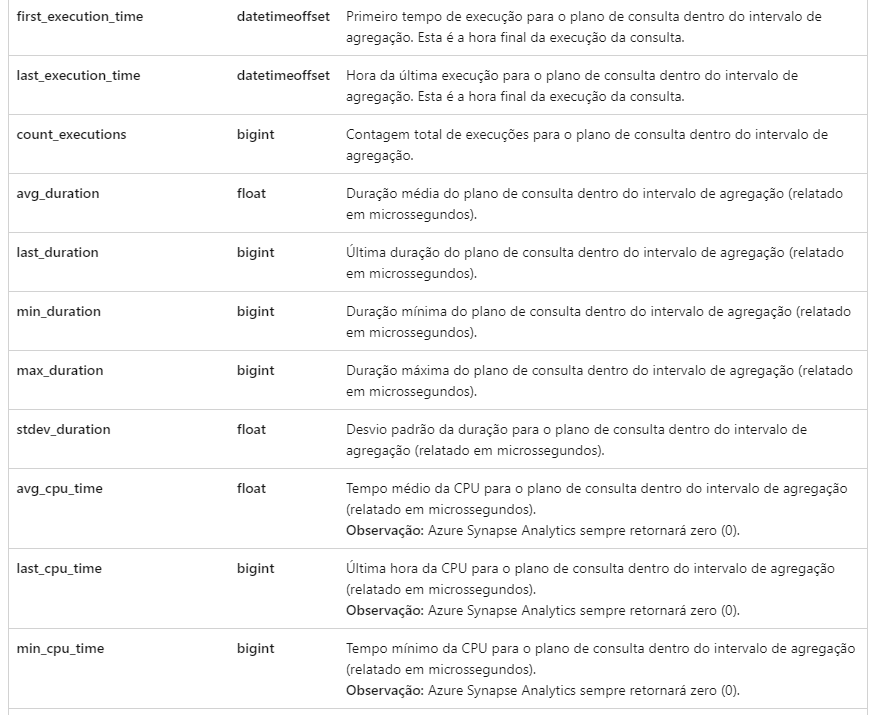

In [4]:
SELECT TOP 10 * FROM  sys.query_store_runtime_stats 

(10 rows affected)

Total execution time: 00:00:00.021

runtime_stats_id,plan_id,runtime_stats_interval_id,execution_type,execution_type_desc,first_execution_time,last_execution_time,count_executions,avg_duration,last_duration,min_duration,max_duration,stdev_duration,avg_cpu_time,last_cpu_time,min_cpu_time,max_cpu_time,stdev_cpu_time,avg_logical_io_reads,last_logical_io_reads,min_logical_io_reads,max_logical_io_reads,stdev_logical_io_reads,avg_logical_io_writes,last_logical_io_writes,min_logical_io_writes,max_logical_io_writes,stdev_logical_io_writes,avg_physical_io_reads,last_physical_io_reads,min_physical_io_reads,max_physical_io_reads,stdev_physical_io_reads,avg_clr_time,last_clr_time,min_clr_time,max_clr_time,stdev_clr_time,avg_dop,last_dop,min_dop,max_dop,stdev_dop,avg_query_max_used_memory,last_query_max_used_memory,min_query_max_used_memory,max_query_max_used_memory,stdev_query_max_used_memory,avg_rowcount,last_rowcount,min_rowcount,max_rowcount,stdev_rowcount,avg_num_physical_io_reads,last_num_physical_io_reads,min_num_physical_io_reads,max_num_physical_io_reads,stdev_num_physical_io_reads,avg_log_bytes_used,last_log_bytes_used,min_log_bytes_used,max_log_bytes_used,stdev_log_bytes_used,avg_tempdb_space_used,last_tempdb_space_used,min_tempdb_space_used,max_tempdb_space_used,stdev_tempdb_space_used
1,1,2,0,Regular,2022-05-25 14:54:29.7800000 +00:00,2022-05-25 14:54:29.7800000 +00:00,1,164217,164217,164217,164217,0,132242,132242,132242,132242,0,74493,74493,74493,74493,0,0,0,0,0,0,2415,2415,2415,2415,0,0,0,0,0,0,1,1,1,1,0,1036,1036,1036,1036,0,133,133,133,133,0,305,305,305,305,0,0,0,0,0,0,0,0,0,0,0
188,1,8,0,Regular,2022-05-26 11:28:51.4930000 +00:00,2022-05-26 11:30:51.6470000 +00:00,2,"89233,5",156497,21970,156497,"67263,5","70477,5",120729,20226,120729,"50251,5","38398,5",74512,2285,74512,"36113,5",0,0,0,0,0,1289,2504,74,2504,1215,0,0,0,0,0,1,1,1,1,0,1036,1036,1036,1036,0,133,133,133,133,0,164,318,10,318,154,0,0,0,0,0,0,0,0,0,0
2,2,3,0,Regular,2022-05-25 15:04:23.3770000 +00:00,2022-05-25 15:09:47.7900000 +00:00,4,"299,25",340,120,380,"104,45903503287785",299,340,119,380,"104,88803554266806","101,25",133,6,133,"54,99263587063272",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36,2,4,0,Regular,2022-05-25 15:24:20.5970000 +00:00,2022-05-25 15:28:27.3400000 +00:00,2,"367,5",372,363,372,"4,5","367,5",372,363,372,"4,5",133,133,133,133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60,2,5,0,Regular,2022-05-25 17:24:12.1970000 +00:00,2022-05-25 17:57:36.5800000 +00:00,10,"428,7",397,102,1004,"279,73274745728287","339,5",397,102,648,"153,22875056594307","107,6",133,6,133,"50,8",0,0,0,0,0,"3,4",0,0,17,"6,56048778674269",0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,"0,6",0,0,3,"1,019803902718557",0,0,0,0,0,0,0,0,0,0
133,2,6,0,Regular,2022-05-25 18:01:42.4830000 +00:00,2022-05-25 18:26:00.2730000 +00:00,9,"307,6666666666667",115,115,362,"70,40994247973791","307,44444444444446",115,115,361,"70,26001707941722","118,88888888888889",6,6,133,"39,91227881241561",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
195,2,9,0,Regular,2022-05-26 13:34:03.6670000 +00:00,2022-05-26 13:47:38.3430000 +00:00,6,"410,3333333333333",313,117,1414,"459,1011762128257","291,8333333333333",313,116,705,"208,38939512364826","69,5",133,6,133,"63,5",0,0,0,0,0,8,0,0,48,"17,88854381999832",0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,6,"2,23606797749979",0,0,0,0,0,0,0,0,0,0
3,3,3,0,Regular,2022-05-25 15:04:23.3800000 +00:00,2022-05-25 15:09:47.7900000 +00:00,4,"30,75",32,24,37,"4,657252408878008","30,75",32,24,37,"4,657252408878008",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37,3,4,0,Regular,2022-05-25 15:24:20.5970000 +00:00,2022-05-25 15:28:27.3430000 +00:00,2,"38,5",34,34,43,"4,5","38,5",34,34,43,"4,5",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61,3,5,0,Regular,2022-05-25 17:24:1

# **<mark>5)  <span style="color: rgb(23, 23, 23); font-family: &quot;Segoe UI&quot;, SegoeUI, &quot;Helvetica Neue&quot;, Helvetica, Arial, sans-serif; font-size: clamp(1.875rem, 22.1053px + 1.64474vw, 2.5rem);">sys.query_context_settings</span></mark>**

### <span style="color: rgb(23, 23, 23); font-family: &quot;Segoe UI&quot;, SegoeUI, &quot;Helvetica Neue&quot;, Helvetica, Arial, sans-serif; font-size: 16px; background-color: rgb(255, 255, 255);">Contém informações sobre a semântica que afeta as configurações de contexto associadas a uma consulta. Há várias configurações de contexto disponíveis no que influenciam a SQL Server semântica de consulta (definindo o resultado correto da consulta). O mesmo texto de consulta compilado em configurações diferentes pode produzir resultados diferentes (dependendo dos dados subjacentes).</span>

<span style="color: rgb(23, 23, 23); font-family: &quot;Segoe UI&quot;, SegoeUI, &quot;Helvetica Neue&quot;, Helvetica, Arial, sans-serif; font-size: 16px; background-color: rgb(255, 255, 255);"><br></span>

<span style="background-color: rgb(255, 255, 255);"><font color="#171717" face="Segoe UI, SegoeUI, Helvetica Neue, Helvetica, Arial, sans-serif"><span style="font-size: 16px;">https://docs.microsoft.com/pt-br/sql/relational-databases/system-catalog-views/sys-query-store-runtime-stats-transact-sql?view=sql-server-ver16</span></font><br></span>

<span style="background-color: rgb(255, 255, 255);"><font color="#171717" face="Segoe UI, SegoeUI, Helvetica Neue, Helvetica, Arial, sans-serif"><span style="font-size: 16px;"><br></span></font></span>

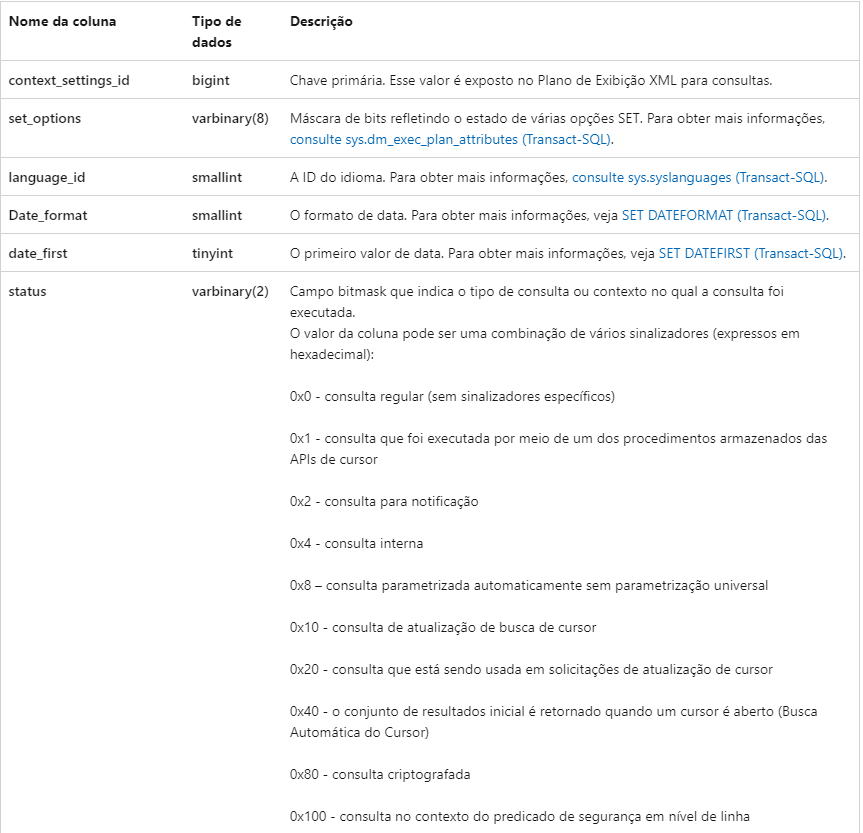

# <mark>**\# Resumo**</mark>

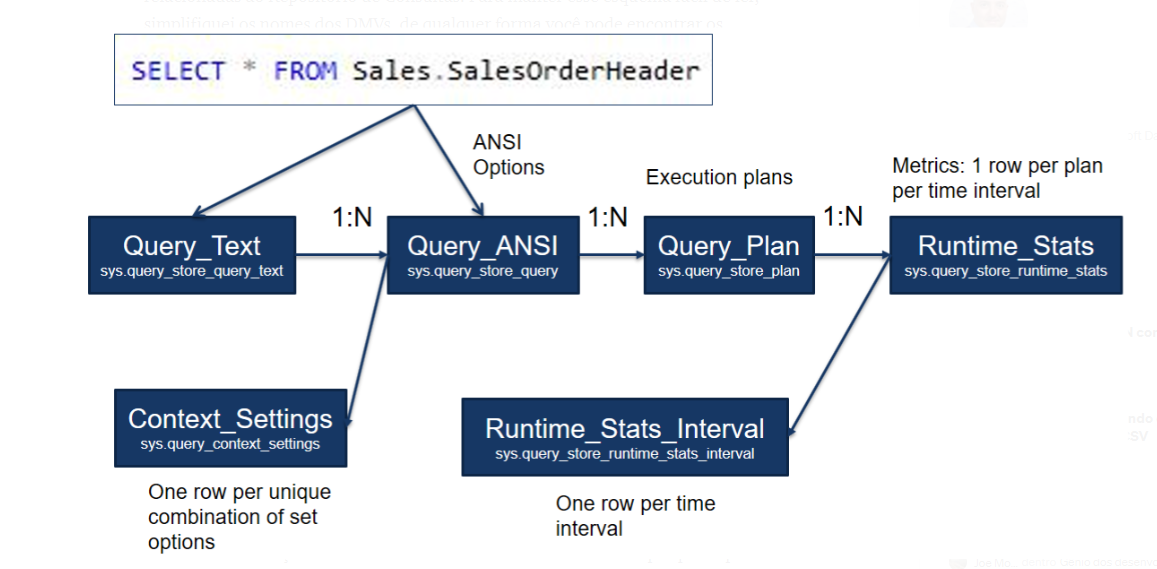

# <mark>**6) Demo**</mark>